## Imports

In [1]:
import time
import json
import numpy as np
import pandas as pd
from pymatgen.core.periodic_table import Specie
from pymatgen.core.structure import Structure
from tqdm.notebook import tqdm

## Read in JSON for Testing

In [2]:
with open('structures_and_energies/188_ABO3_structures_and_energies_11_tilts.json') as json_file:
    dct = json.load(json_file)
for key in list(dct.keys()):
    dct[key]['structures'] = [Structure.from_dict(s) for s in dct[key]['structures']]

# Benchmark gii_calculator.py

## Compute Matminer GII - Benchmarking

In [3]:
from matminer.featurizers.structure.bonding import GlobalInstabilityIndex
# matminer GlobalInstabilityIndex uses bvparm16.cif, which is the default for GIICalculator

In [4]:
benchmark_structure = dct['NaNbO3']['structures'][1]

In [5]:
start_time = time.time()
mm_gii_calc = GlobalInstabilityIndex(r_cut=4)
mm_gii = mm_gii_calc.featurize(benchmark_structure)[0]
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.4777829647064209 seconds ---


In [6]:
mm_gii

0.22997194431320916

## Compute GIICalculator GII

In [7]:
from gii_calculator import GIICalculator

In [8]:
start_time = time.time()
#gii_calc = GIICalculator(method='CrystalNN')
gii_calc = GIICalculator(method='Cutoff', cutoff=4)
gii = gii_calc.GII(benchmark_structure)
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.08564543724060059 seconds ---


In [9]:
gii

0.22997194431320914

In [10]:
gii_calc.params_dict

{'Cation': [Species Na+, Species Nb5+],
 'Anion': [Species O2-, Species O2-],
 'R0': [1.803, 1.911],
 'B': [0.37, 0.37]}

# Benchmark site_optimization.py

## Perform the Site Optimization

In [12]:
from site_optimization import SiteClusterOptimization

In [18]:
sco = SiteClusterOptimization()

In [19]:
start_time = time.time()
final_structure = sco.minimize_cluster_di_squared(benchmark_structure, site_ind=16) # pass the index of site to be optimized
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 3.984825849533081 seconds ---


In [20]:
start_time = time.time()
start_gii = gii_calc.GII(benchmark_structure)
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.14157724380493164 seconds ---


In [21]:
start_gii

0.22741774664473707

In [22]:
start_time = time.time()
final_gii = gii_calc.GII(final_structure, use_sym=False)
print("Time taken: --- %s seconds ---" % (time.time() - start_time))

Time taken: --- 0.3294098377227783 seconds ---


In [23]:
final_gii

0.2222068229123708

## Perform the Structure Optimization 

In [12]:
from site_optimization import GIIMinimizer

In [25]:
gii_minimizer = GIIMinimizer(benchmark_structure, convergence_tolerance=0.01)
# All sites optimized until optimization of said site changes GII by < convergence_tolerance

In [26]:
optimized_structure = gii_minimizer.gii_minimization(opt_method='max')

Step 1 complete; 0.22741774664473727 --> 0.21685468242809414
Step 2 complete; 0.21685468242809414 --> 0.21253671761744256
Step 3 complete; 0.21253671761744256 --> 0.20319583095480914
Step 4 complete; 0.20319583095480914 --> 0.19929305787714166
Step 5 complete; 0.19929305787714166 --> 0.17406125117144214
Step 6 complete; 0.17406125117144214 --> 0.1541425987472521
Step 7 complete; 0.1541425987472521 --> 0.14735253314386446
Step 8 complete; 0.14735253314386446 --> 0.12605574185146776
Step 9 complete; 0.12605574185146776 --> 0.1172540398089425
Step 10 complete; 0.1172540398089425 --> 0.11532954906197346
Step 11 complete; 0.11532954906197346 --> 0.11098630269185894
Step 12 complete; 0.11098630269185894 --> 0.10514996486333666
Step 13 complete; 0.10514996486333666 --> 0.10514996486333666
Step 14 complete; 0.10514996486333666 --> 0.10514996486333666
Step 15 complete; 0.10514996486333666 --> 0.10512042010554813
Step 16 complete; 0.10512042010554813 --> 0.1051185729262532
Step 17 complete; 0.10

In [27]:
# Get the change in GII following optimization for each site in the structure, show that it is < convergence_tolerance
for i in range(len(gii_minimizer.diffs)):
    print('Specie: %s, delGII of optimization step: %s' % (optimized_structure[i].specie, gii_minimizer.diffs[i]))

Specie: Na+, delGII of optimization step: 0.006511574041070112
Specie: Na+, delGII of optimization step: 0.007380391101802525
Specie: Na+, delGII of optimization step: 0.0018892742339008256
Specie: Na+, delGII of optimization step: 0.00614137470116205
Specie: Nb5+, delGII of optimization step: 2.9544757788532716e-05
Specie: Nb5+, delGII of optimization step: 0.0
Specie: Nb5+, delGII of optimization step: 1.847179294925394e-06
Specie: Nb5+, delGII of optimization step: 0.0
Specie: O2-, delGII of optimization step: 0.008801702042525256
Specie: O2-, delGII of optimization step: 0.001924490746969043
Specie: O2-, delGII of optimization step: 0.004343246370114517
Specie: O2-, delGII of optimization step: 0.0058363378285222756
Specie: O2-, delGII of optimization step: 0.006790065603387657
Specie: O2-, delGII of optimization step: 2.7755575615628914e-17
Specie: O2-, delGII of optimization step: 0.002665507676445314
Specie: O2-, delGII of optimization step: 0.0010834205073378123
Specie: O2-, de

# Benchmark parameterization.py

In [11]:
from parameterization import BVParamOptimization
from parameterization import GeneralBVParamOptimizationOuterLoop
from parameterization import CompositionSpecificBVParamOptimizationOuterLoop
from pymatgen.core.periodic_table import Specie

In [12]:
# Define variables and get the starting parameters for cation-anion pairs present

use_cmpd = 'NaNbO3'
cation = Specie('Nb', 5)
anion = Specie('O', -2)
cations_anions = [(Specie('Nb', 5), Specie('O', -2)), (Specie('Na', 1), Specie('O', -2))]
options = {'gtol': 0.01, 'xtol': 0.01, 'barrier_tol': 0.01, 'disp': True, 'verbose': 0} # Changed from default

opt_gii_calc = GIICalculator()
for cmpd in list(dct.keys()):
    s = dct[cmpd]['structures'][0]
    for pair in cations_anions:
        if pair[0] in s.species and pair[1] in s.species:
            opt_gii_calc.GII(s)

## Parameterization that minimizes site discrepancy factor RMSD

### Composition-Specific Parameterization - R0 Only

In [39]:
rmsd_cs_parameterization = CompositionSpecificBVParamOptimizationOuterLoop(dct, [use_cmpd], gii_calc.params_dict)

In [40]:
rmsd_cs_parameterization.parameter_optimization(obj_func='di2_rmsd', parameterize='R0')

0.5308895346573191
0.5308895112541309
0.5308891838870685
63.015576647717445
63.01557672285028
63.01558459206464
0.5282671110507696
0.5282671003017034
0.5282675406421314
0.7404243226939411
0.7404243084034181
0.7404239906841008
0.2954180377835418
0.2954180292579315
0.29541767147706044
0.44558215589695394
0.4455821491725202
0.4455825768390654
0.16583447805799414
0.16583447037603738
0.16583479955750247
0.9158437566387116
0.9158437523431111
0.9158434405088176
0.3635283985563304
0.3635283920154361
0.3635280352789497
0.20315853657454244
0.20315852942325102
0.20315818163988209
`xtol` termination condition is satisfied.
Number of iterations: 10, function evaluations: 30, CG iterations: 11, optimality: 1.11e+01, constraint violation: 0.00e+00, execution time: 6.1e+01 s.
All parameters optimized using convergence criteria


In [41]:
rmsd_cs_parameterization.updated_params_by_composition, rmsd_cs_parameterization.starting_params

({'NaNbO3': {'Cation': [Species Na+, Species Nb5+],
   'Anion': [Species O2-, Species O2-],
   'R0': [1.812, 1.948],
   'B': [0.37, 0.37]}},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Single Parameter Optimization

In [42]:
single_parameterization_rmsd = BVParamOptimization([dct['NaNbO3']['structures']], [dct['NaNbO3']['energies']], 
                                                          gii_calc.params_dict, [cation], [anion], 
                                                          obj_func='di2_rmsd', options=options)

In [43]:
rmsd_optimized_param_dict = single_parameterization_rmsd.param_optimizer()

0.4251867164064254
0.42518636563617485
63.280137501585074
63.28014550644829
0.4215481128367954
0.4215485418104881
0.6405397907050021
0.6405394588520444
0.1986049751186708
0.1986046088775735
0.34005285300513977
0.3400532733401292
0.06217008191721985
0.06217039318185852
0.7223628056896995
0.7223624811561369
0.22460630986753102
0.22460594448746252
`xtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 18, CG iterations: 8, optimality: 1.07e+01, constraint violation: 0.00e+00, execution time: 1e+01 s.


In [44]:
rmsd_optimized_param_dict, gii_calc.params_dict

({'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.947],
  'B': [0.37, 0.37]},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Multiple Parameter Optimization

In [45]:
rmsd_pol = GeneralBVParamOptimizationOuterLoop(dct, cations_anions, opt_gii_calc.params_dict)
rmsd_pol.parameter_optimization(obj_func='di2_rmsd', init_steps=1)

(Species Nb5+, Species O2-) 1
0.4969390575513647
0.4969387160501041
62.294816408595636
62.294824297855406
0.34363124443999804
0.3436316535316038
0.6840425074428501
0.6840421804589454
0.2613087595497971
0.2613084121266947
0.2670507273521087
0.2670511195419649
0.0904857709845064
0.0904857026085591
0.09209978152058317
0.09209988155868214
0.08909100222462095
0.08909100247134066
0.0890909847560686
0.08909098474949245
`gtol` termination condition is satisfied.
Number of iterations: 10, function evaluations: 20, CG iterations: 9, optimality: 2.26e-04, constraint violation: 0.00e+00, execution time: 2.3e+01 s.
1.949 0.37
(Species Na+, Species O2-) 1
0.13569325932729512
0.13569327382202984
0.7659563949669042
0.7659563831005939
0.2544913514129494
0.25449130618335986
0.14056527663663793
0.14056525482565752
0.1334338297270636
0.13343382442091917
0.1330659864098037
0.13306598721757404
0.13305754624328342
0.13305754622897045
`gtol` termination condition is satisfied.
Number of iterations: 7, functio

In [46]:
rmsd_pol.starting_params

{'Cation': [Species Na+,
  Species Nb5+,
  Species Sb5+,
  Species Ta5+,
  Species W5+,
  Species Ag+],
 'Anion': [Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-],
 'R0': [1.803, 1.911, 1.912, 1.92, 1.881, 1.842],
 'B': [0.37, 0.37, 0.37, 0.37, 0.37, 0.37]}

In [47]:
rmsd_pol.updated_params

{'Cation': [Species Na+,
  Species Nb5+,
  Species Sb5+,
  Species Ta5+,
  Species W5+,
  Species Ag+],
 'Anion': [Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-,
  Species O2-],
 'R0': [1.793, 1.949, 1.912, 1.92, 1.881, 1.842],
 'B': [0.37, 0.37, 0.37, 0.37, 0.37, 0.37]}

## Parameterization considering GII-DFT Energetics Relationship

### Composition-Specific Parameterization

In [31]:
gs_cs_parameterization = CompositionSpecificBVParamOptimizationOuterLoop(dct, [use_cmpd], gii_calc.params_dict)

In [32]:
gs_cs_parameterization.parameter_optimization(obj_func='gii_gs')

0.8759271965561727
0.8759270114046712
0.8759272979182438
0.9970649010355069
0.997064900735736
0.9970649013574377
0.9581090510603086
0.9581089885304245
0.9581091037970134
0.9493711118565613
0.949371030490742
0.9493711789234135
0.8799701953456404
0.8799699466098394
0.8799705224470059
0.9702919813944775
0.9702919619256541
0.9702920029424218
0.9561926342495858
0.9561925776816448
0.9561926801096746
0.9347960660080918
0.9347959418044921
0.9347961348487588
0.9523393502424893
0.9523392528798112
0.9523394259009775
0.6920518486763058
0.6920513261740705
0.6920518901729429
0.8778407975826956
0.8778405160533279
0.8778412054640523
0.8277399648027359
0.8277395774707722
0.8277404653086947
0.8600146867128924
0.8600143266834223
0.8600148477239995
0.8504086349470362
0.8504082583889168
0.850408889016567
0.8500255609987467
0.8500251844500756
0.8500258304032184
0.931128287105023
0.9311281058911738
0.9311284435754681
0.9449883725067338
0.9449882302040133
0.9449885570234362
0.9435776352470792
0.94357749939077

In [50]:
gs_cs_parameterization.updated_params_by_composition, gs_cs_parameterization.starting_params

({'NaNbO3': {'Cation': [Species Na+, Species Nb5+],
   'Anion': [Species O2-, Species O2-],
   'R0': [1.802, 1.945],
   'B': [0.37, 0.37]}},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Single Parameter Optimization

In [52]:
single_parameterization_gii = BVParamOptimization([dct['NaNbO3']['structures']], [dct['NaNbO3']['energies']], 
                                                         gii_calc.params_dict, [cation], [anion], options=options)

In [53]:
gii_optimized_param_dict = single_parameterization_gii.param_optimizer()

0.8759271965561727
0.8759272979182438
0.9967800101556453
0.9967800108992403
0.9619289177254557
0.9619289733733777
0.984418093510638
0.9844181018430954
0.9836163600494846
0.9836163664459969
0.9827209932647463
0.982721000745698
0.9335406405642902
0.9335407078168376
0.9974258203794442
0.9974258205344567
0.9418518786446923
0.9418519455268382
0.9972529524684045
0.997252952763292
0.9625979157353322
0.9625980930116182
0.9955935986250433
0.9955936005956567
0.9794640807542064
0.9794641566457716
`gtol` termination condition is satisfied.
Number of iterations: 10, function evaluations: 26, CG iterations: 9, optimality: 8.28e-04, constraint violation: 0.00e+00, execution time: 2.7e+01 s.


In [54]:
gii_optimized_param_dict, gii_calc.params_dict

({'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.948],
  'B': [0.37, 0.37]},
 {'Cation': [Species Na+, Species Nb5+],
  'Anion': [Species O2-, Species O2-],
  'R0': [1.803, 1.911],
  'B': [0.37, 0.37]})

### Multiple Parameter Optimization

In [11]:
# gii_pol = GeneralBVParamOptimizationOuterLoop(dct, cations_anions, opt_gii_calc.params_dict)

In [12]:
# gii_pol.parameter_optimization(init_steps=1, max_steps=3)

# Testing analysis.py

In [11]:
from analysis import stats

In [12]:
with open('structures_and_energies/188_ABO3_structures_and_energies_11_tilts.json') as json_file:
    dct_full = json.load(json_file)
for key in list(dct.keys()):
    dct_full[key]['structures'] = [Structure.from_dict(s) for s in dct_full[key]['structures']]

In [13]:
def print_stats(gs_giis, pearsons, correctly_ordered, correctly_identified_gs):
    print('Number of gii_gs <= 0.1: %s/%s' % (str(np.sum([1 for gs_gii in gs_giis if gs_gii <= 0.1])), len(gs_giis)))
    print('Number of ground states correctly identified by GII: %s' % str(correctly_identified_gs[0]))
    print('Minimum Pearson: %s' % str(sorted(pearsons)[1]))
    print('N >= 8: %s' % str(np.sum([1 for co in correctly_ordered if co >= 8])))

## Composition-Specific Distributions

In [38]:
from visualization import plot_giis_pearsons

### p = 0.65

In [39]:
with open('optimized_parameters/59_cs_11_tilts_p_0.65_optimized_parameters.json') as json_file:
    cs_065_params_dct = json.load(json_file)
for cmpd in list(cs_065_params_dct.keys()):
    cs_065_params_dct[cmpd]['Cation'] = [Specie.from_dict(s) for s in cs_065_params_dct[cmpd]['Cation']]
    cs_065_params_dct[cmpd]['Anion'] = [Specie.from_dict(s) for s in cs_065_params_dct[cmpd]['Anion']]

In [40]:
gs_giis_065, pearsons_065, correctly_ordered_065, correctly_identified_gs_065, cmpds_used_065 = stats(dct_full, 
                                                                                                     cs_065_params_dct)

 55%|████████████████████████████████████████████▊                                    | 104/188 [02:48<02:26,  1.74s/it]

NaWO3 min_gii 0.254
NaWO3 pearson 0.652


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 180/188 [04:57<00:13,  1.68s/it]

YbAlO3 pearson 0.232


100%|█████████████████████████████████████████████████████████████████████████████████| 188/188 [05:10<00:00,  1.65s/it]


In [41]:
from visualization import plot_giis_pearsons

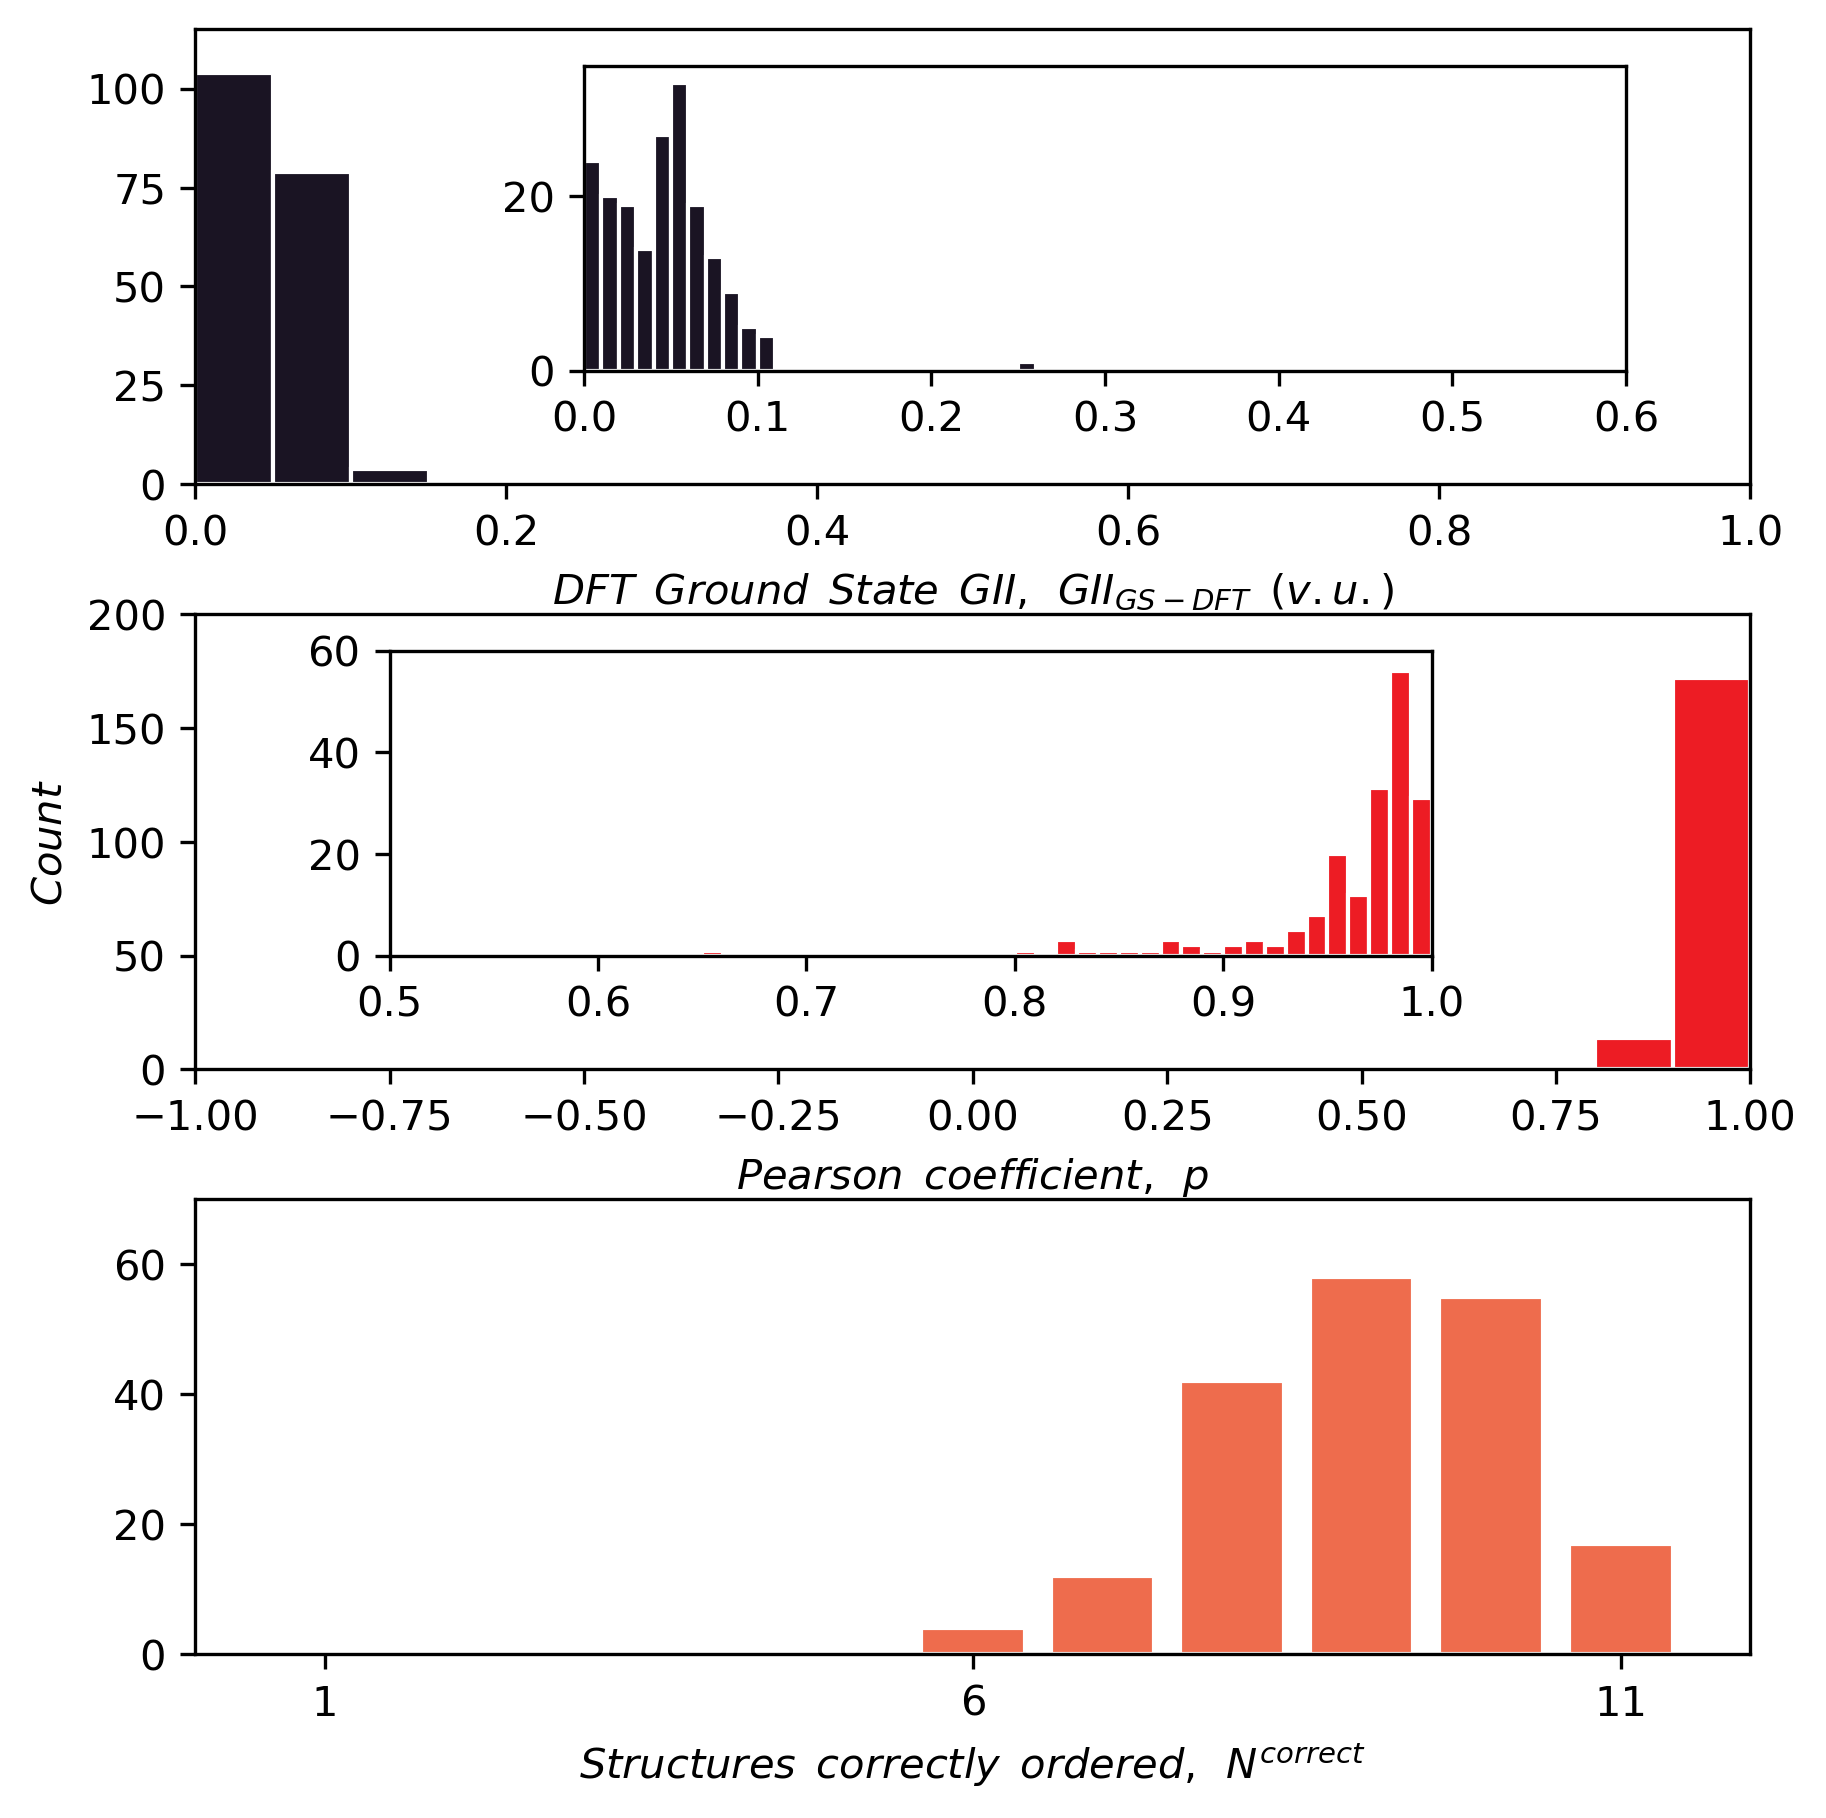

In [42]:
plot_giis_pearsons(gs_giis_065, pearsons_065, correctly_ordered_065, name='figures/composition_specific_distribution.png')

In [43]:
print_stats(gs_giis_065, pearsons_065, correctly_ordered_065, correctly_identified_gs_065)

Number of gii_gs <= 0.1: 183/188
Number of ground states correctly identified by GII: 174
Minimum Pearson: 0.652
N >= 8: 172


## Composition-Specific Plotting

In [23]:
from visualization import plot_by_species

DyCoO3 0.078 0.953 7
GdCoO3 0.063 0.942 7
HoCoO3 0.078 0.944 6
NdCoO3 0.039 0.85 7
PrCoO3 0.034 0.862 8
SmCoO3 0.068 0.915 9
TbCoO3 0.079 0.952 8
YCoO3 0.077 0.972 8


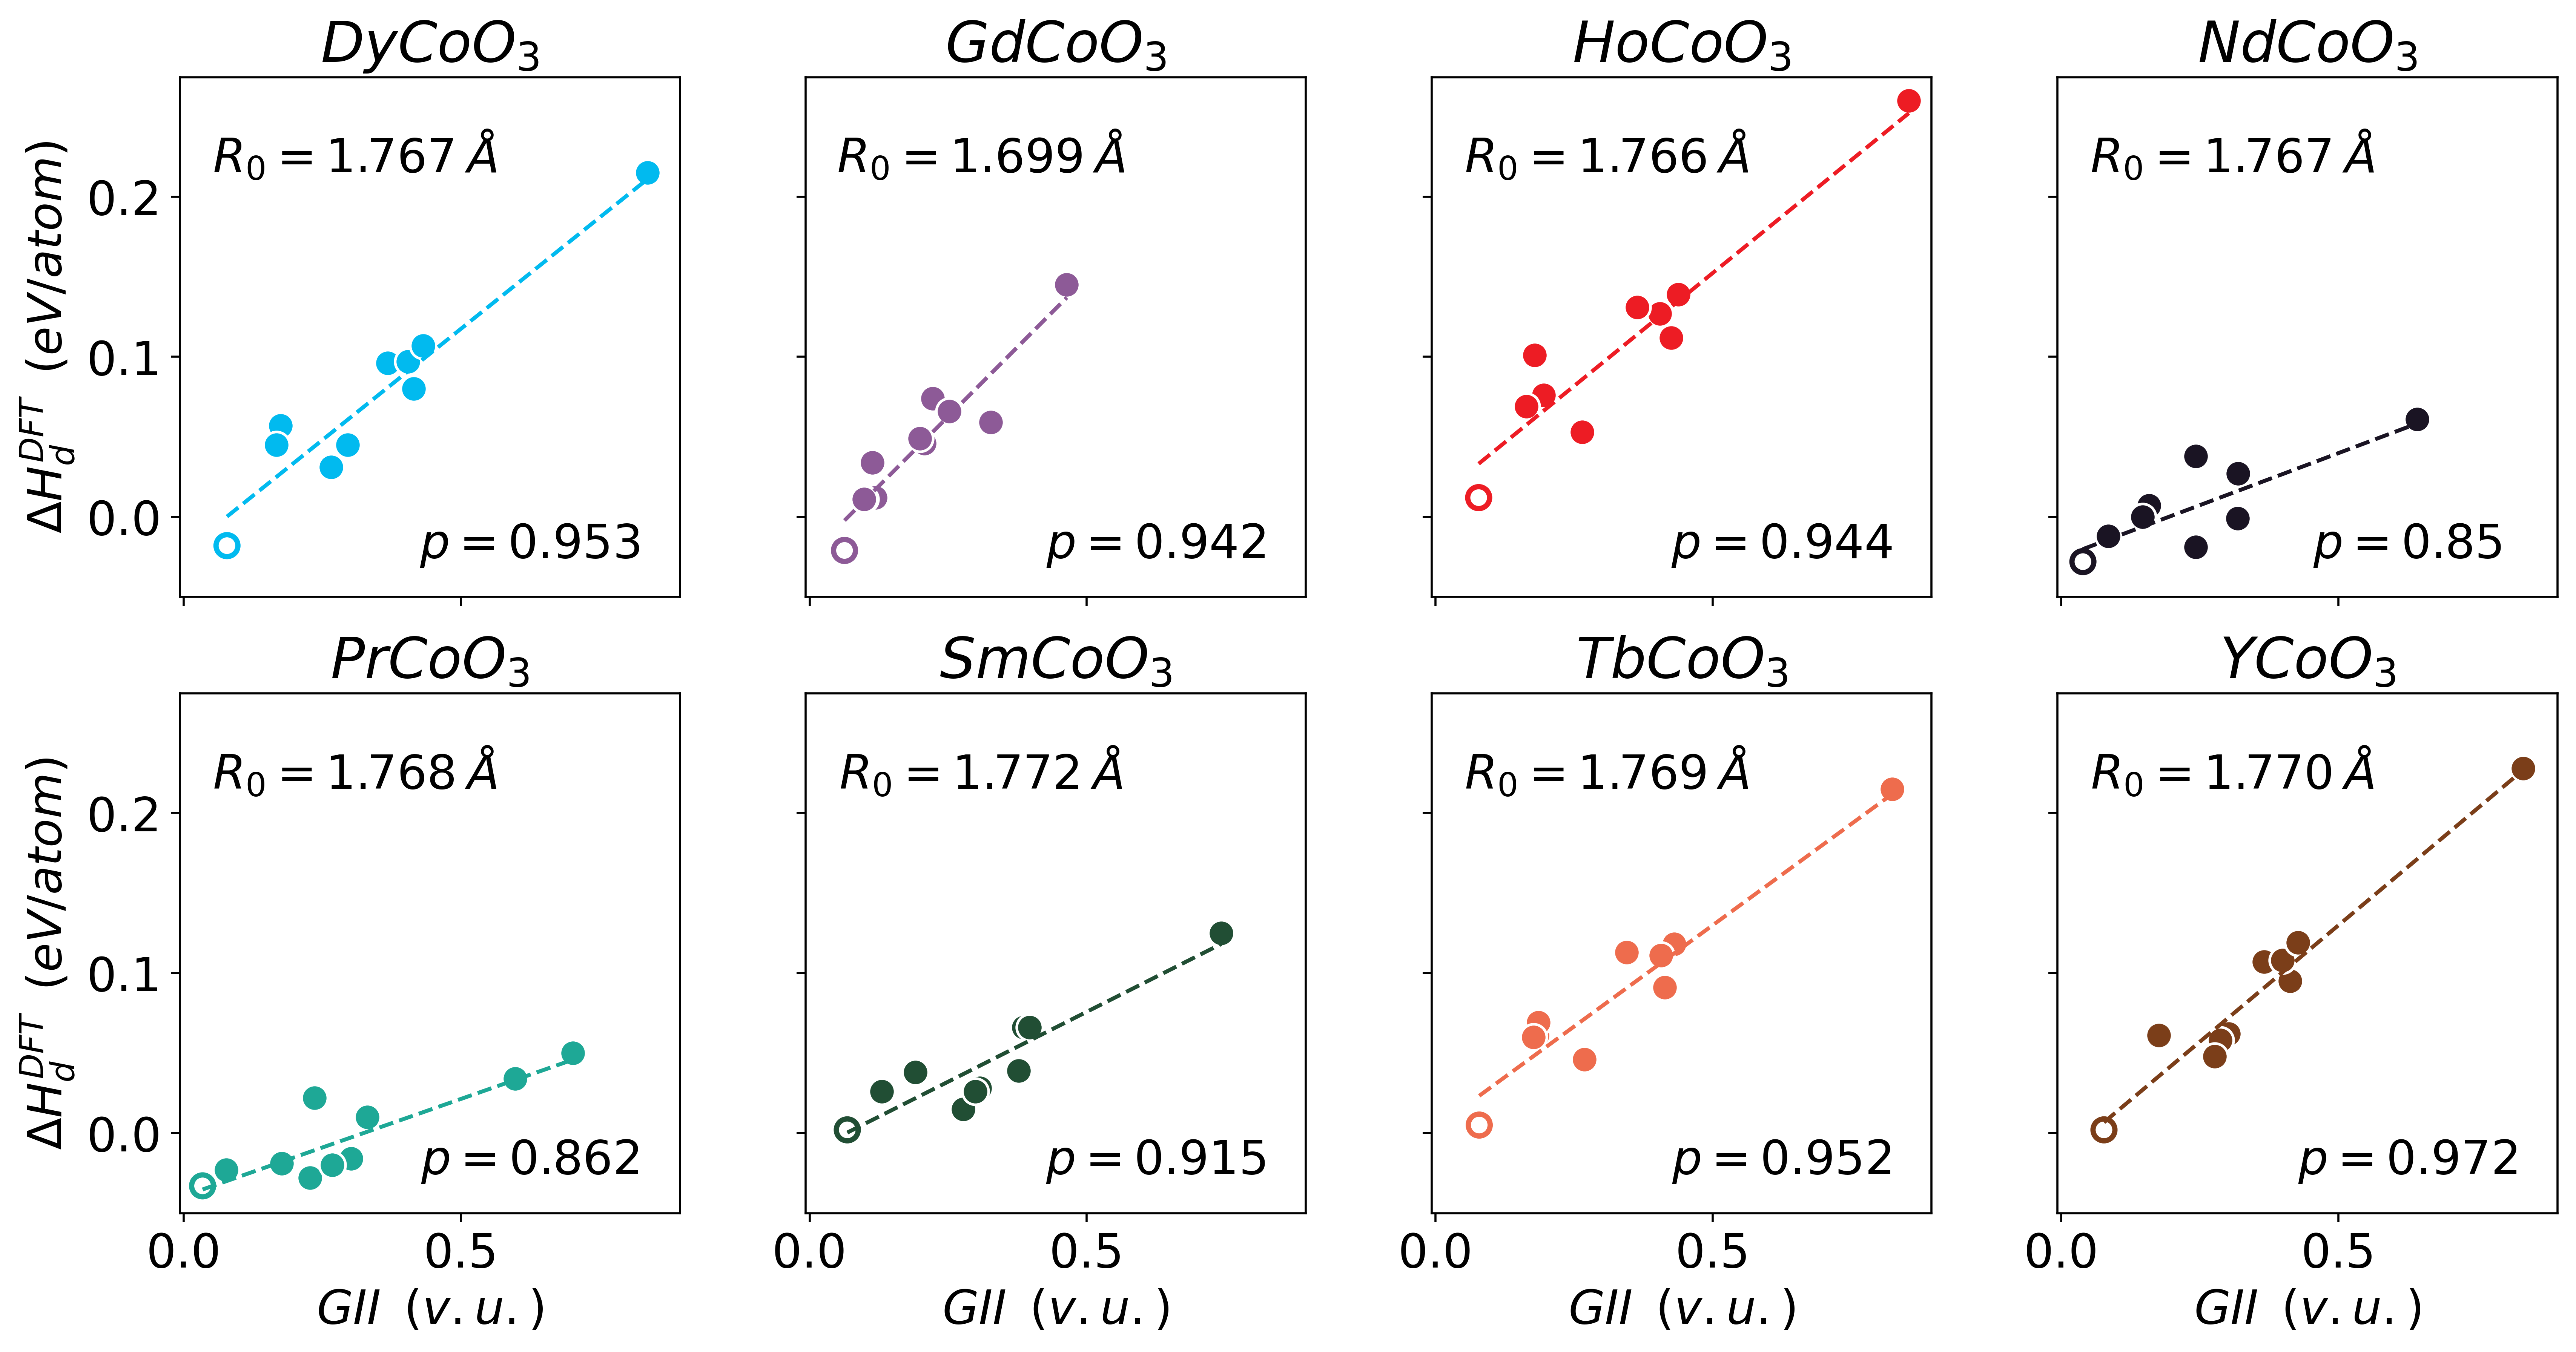

In [22]:
pair = (Specie('Co', 3), Specie('O', -2))
plot_by_species(pair, dct_full, cs_065_params_dct, name='figures/composition_specific_GII_dHd.png')

## IQR Distribution Plotting

In [19]:
from visualization import periodic_table_heatmap_plot

In [20]:
def get_cations_and_counts(dct):
    all_cations = []
    for key in list(dct.keys()):
        s = dct[key]['structures'][0]
        cats = list(np.unique([c for c in s.species if np.sign(c.oxi_state) == 1]))
        all_cations.append(cats)
    unique_cations, unique_counts = np.unique(all_cations, return_counts=True)
    return list(unique_cations), list(unique_counts)

In [21]:
cations, counts = get_cations_and_counts(dct_full)

36


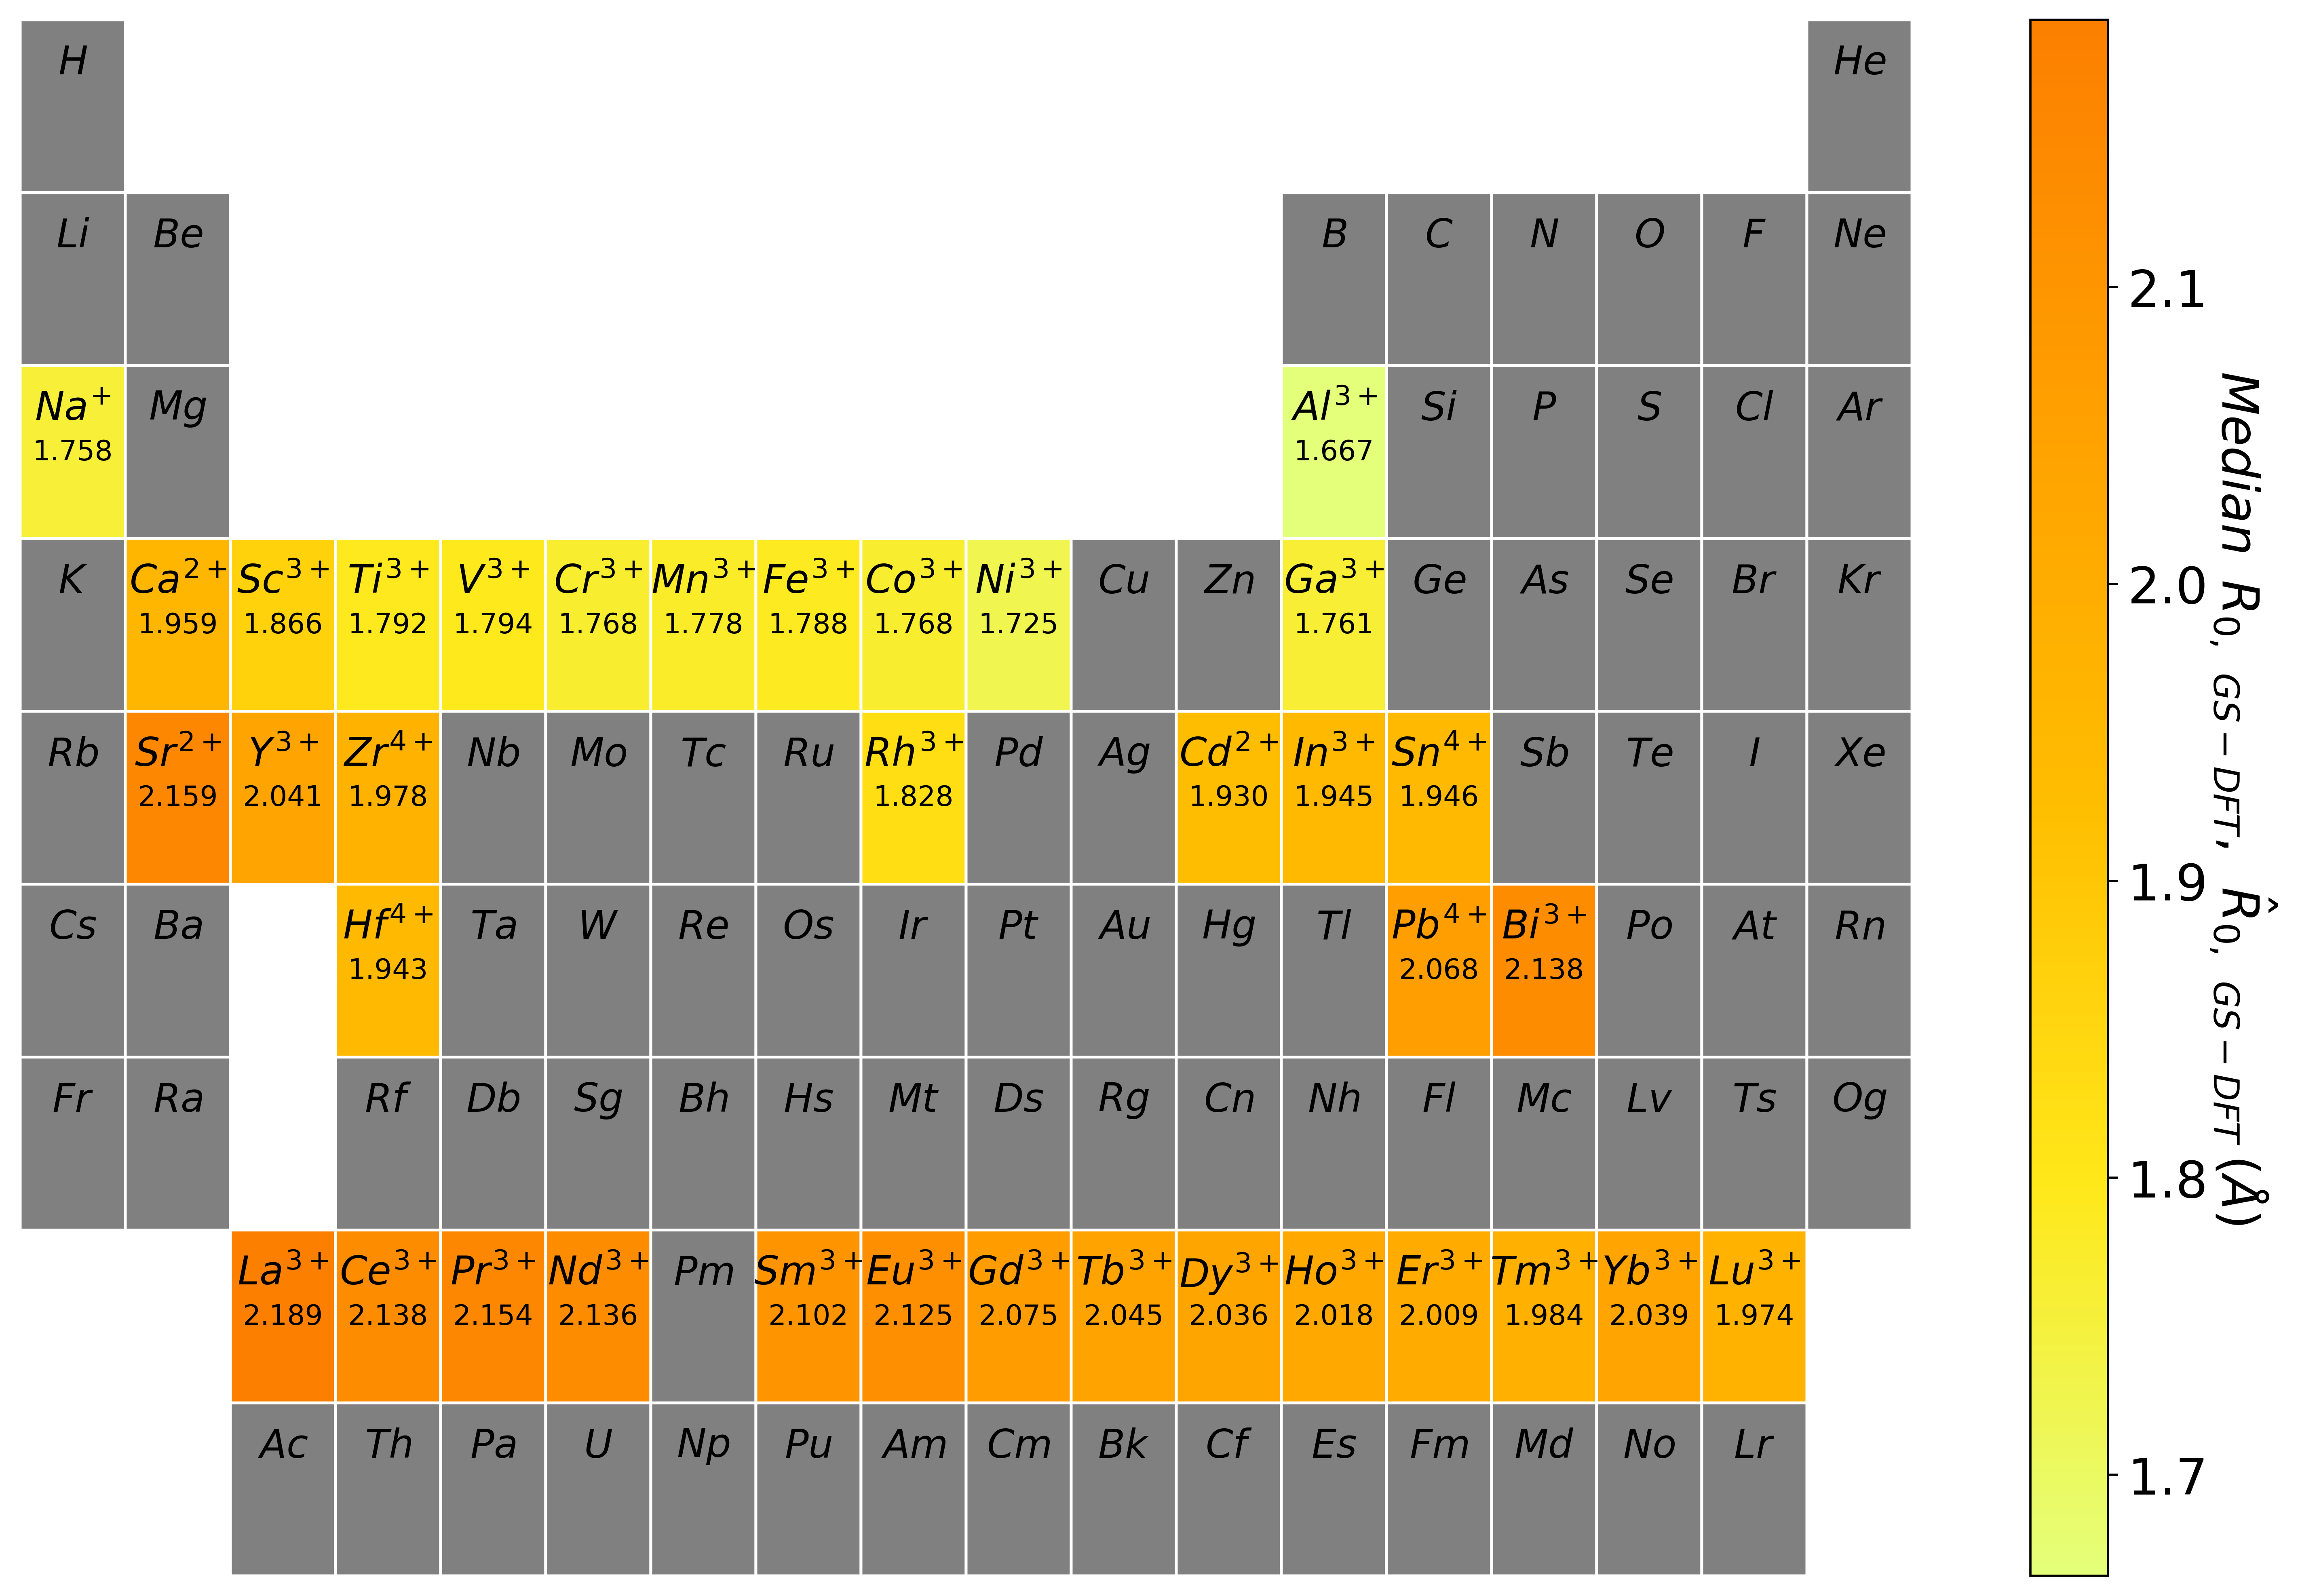

In [22]:
import warnings
warnings.filterwarnings("ignore")
used, meds = periodic_table_heatmap_plot(cations, counts, cs_065_params_dct, show='median', name='figures/composition_specific_median.png')

36


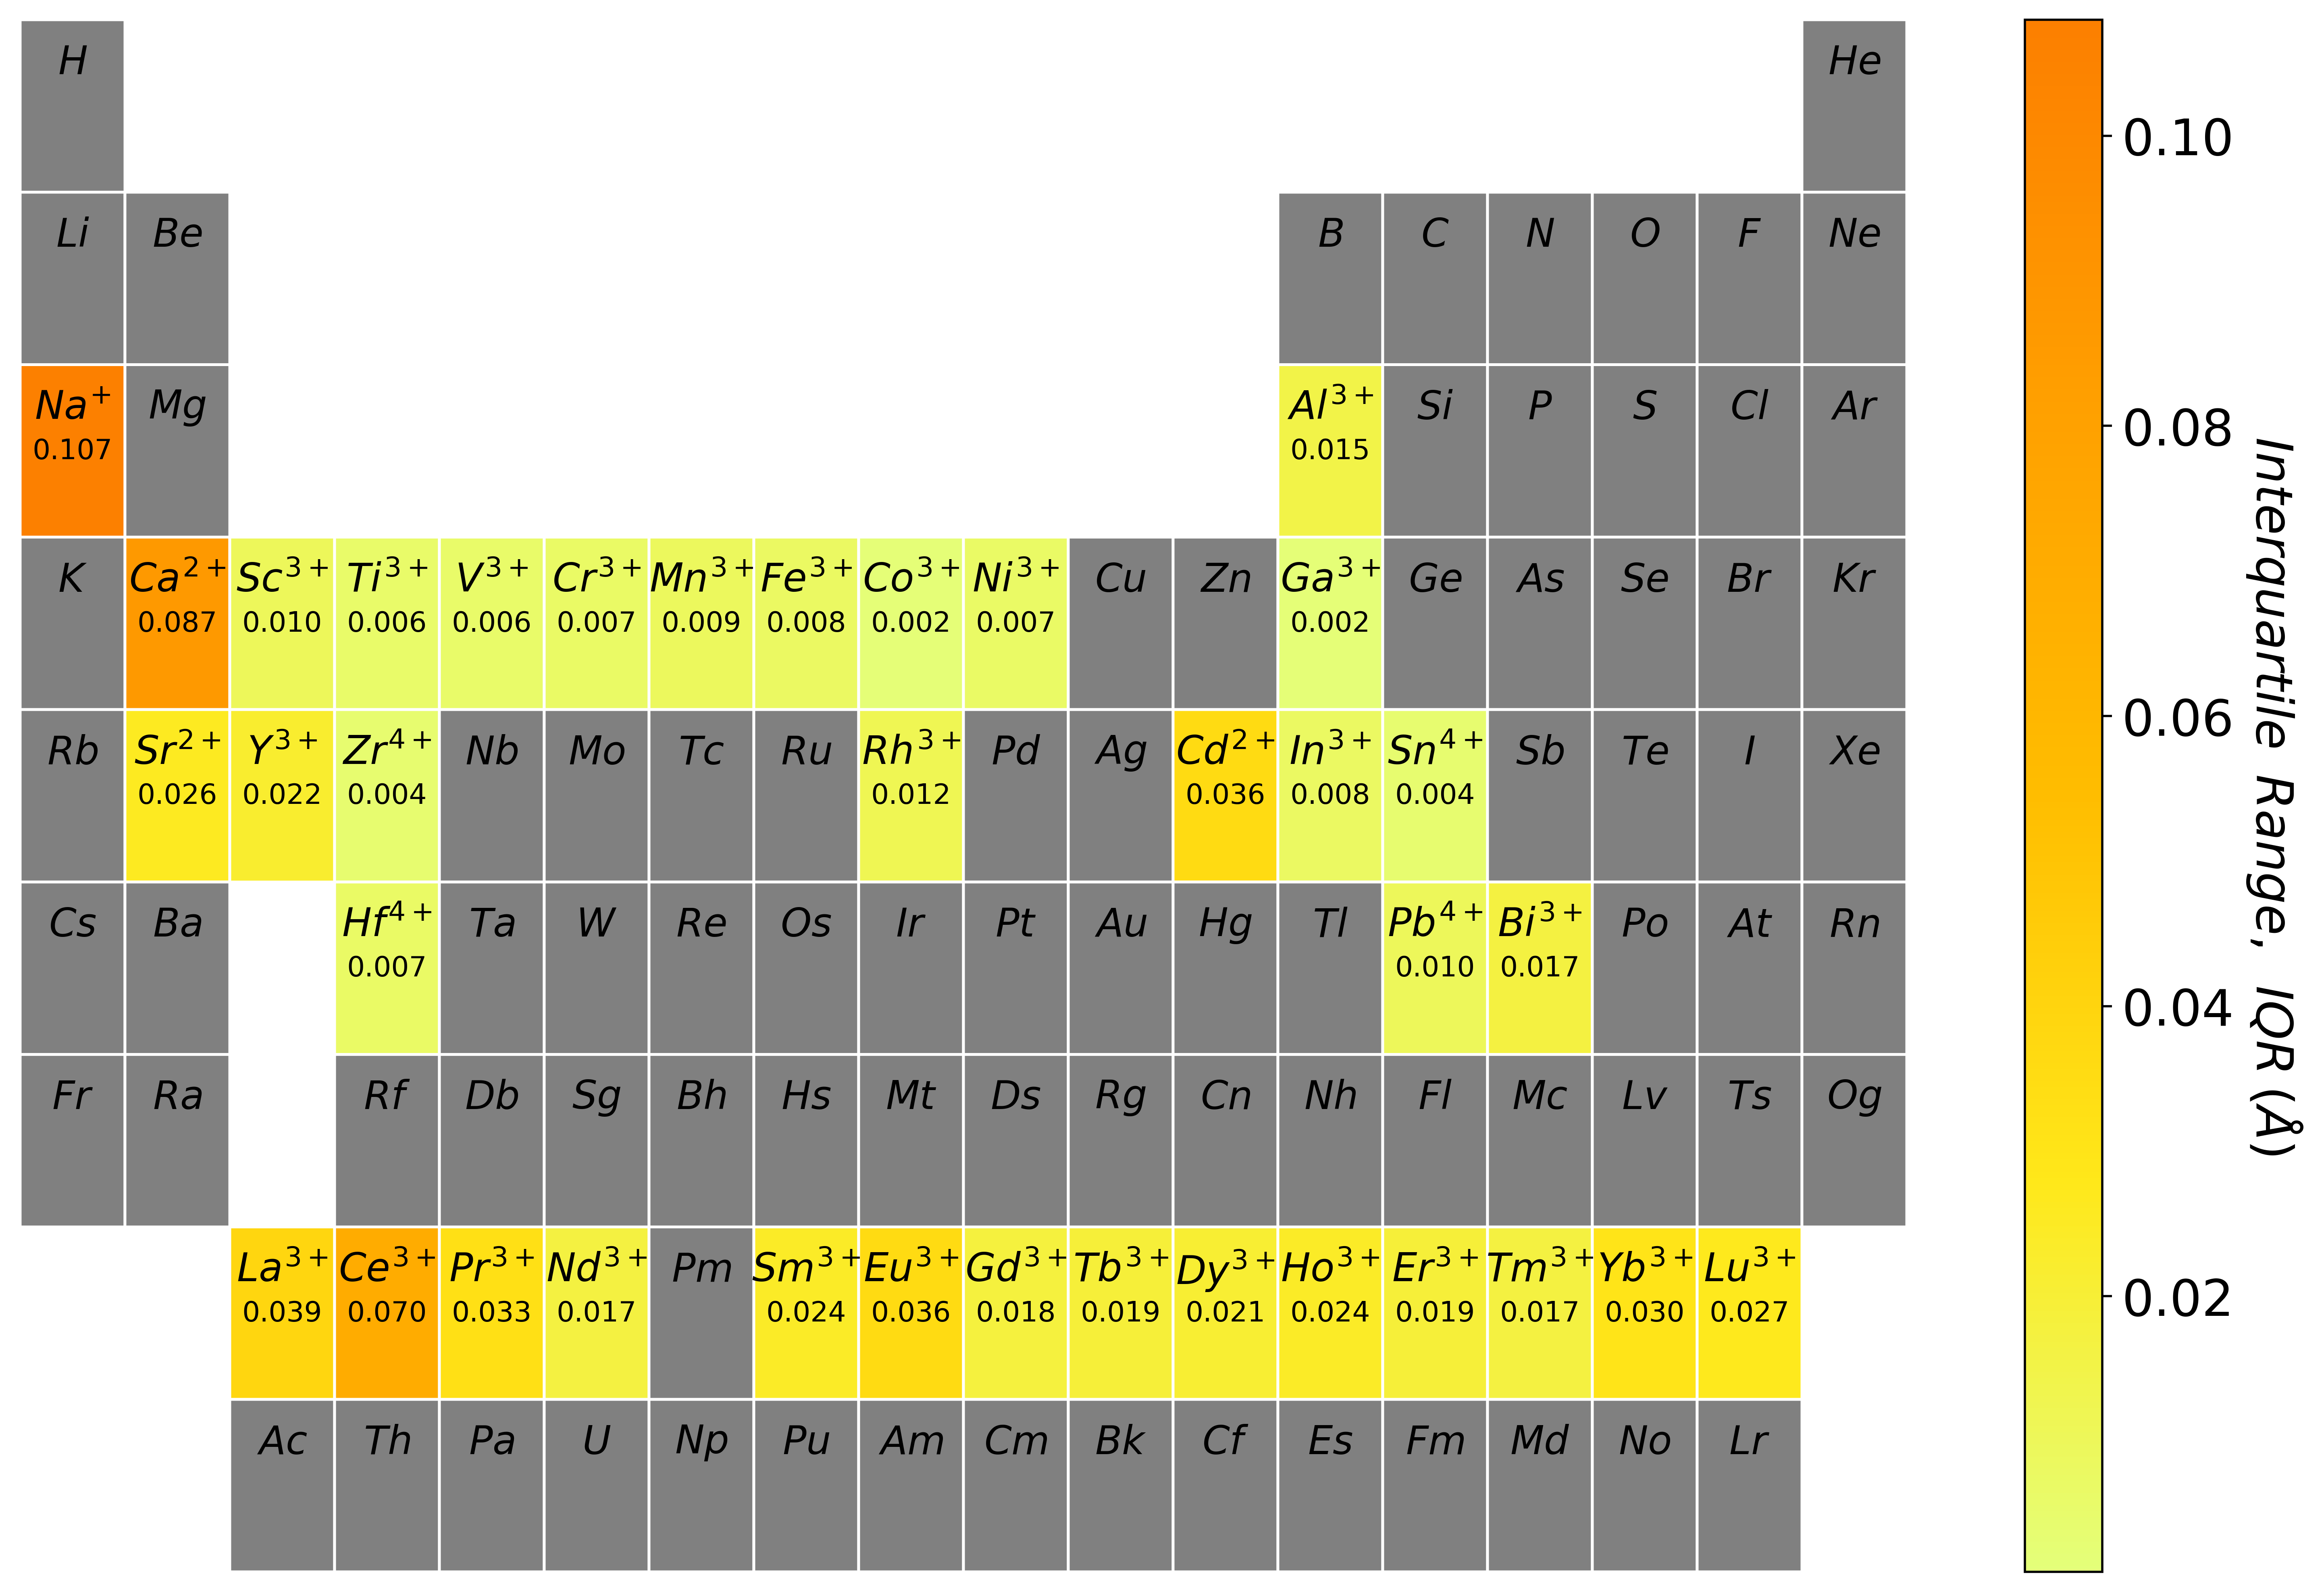

In [23]:
used, iqrs = periodic_table_heatmap_plot(cations, counts, cs_065_params_dct, show='IQR', name='figures/composition_specific_IQR.png')

## Get the publication thumbnail

In [24]:
from visualization import pub_thumbnail

In [25]:
## Use the general parameters that are derived with 63 cations; will need to change this 

In [26]:
with open('optimized_parameters/59_g_11_tilts_p_0.8_optimized_parameters_0.01_6.json') as json_file:
    g_08_params_dct = json.load(json_file)

g_08_params_dct['Cation'] = [Specie.from_dict(s) for s in g_08_params_dct['Cation']]
g_08_params_dct['Anion'] = [Specie.from_dict(s) for s in g_08_params_dct['Anion']]

In [27]:
thumbnail_gii = GIICalculator(params_dict=g_08_params_dct)
cmpd_energies = dct['LaTiO3']['energies']
cmpd_giis = [thumbnail_gii.GII(s) for s in dct['LaTiO3']['structures']]

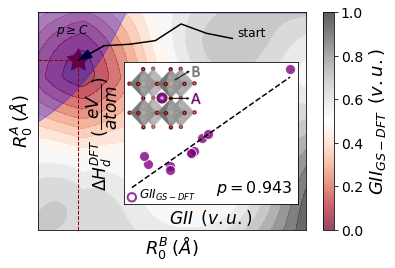

In [28]:
pub_thumbnail(cmpd_giis, cmpd_energies, name='figures/thumbnail.png')

## Compare R0 Parameters

In [29]:
from visualization import compare_rmsd_to_gs_dft_R0

In [30]:
## Change this figure size

In [31]:
with open('optimized_parameters/59_g_11_tilts_rmsd_optimized_parameters.json') as json_file:
    g_rmsd_params_dct = json.load(json_file)

g_rmsd_params_dct['Cation'] = [Specie.from_dict(s) for s in g_rmsd_params_dct['Cation']]
g_rmsd_params_dct['Anion'] = [Specie.from_dict(s) for s in g_rmsd_params_dct['Anion']]

Alkali metal 1 0.023
Alkaline earth metal 4 0.03
Lanthanide 15 0.028
Metalloid 3 -0.009
Post-transition metal 8 -0.008
Transition metal 28 -0.021


<Figure size 432x288 with 0 Axes>

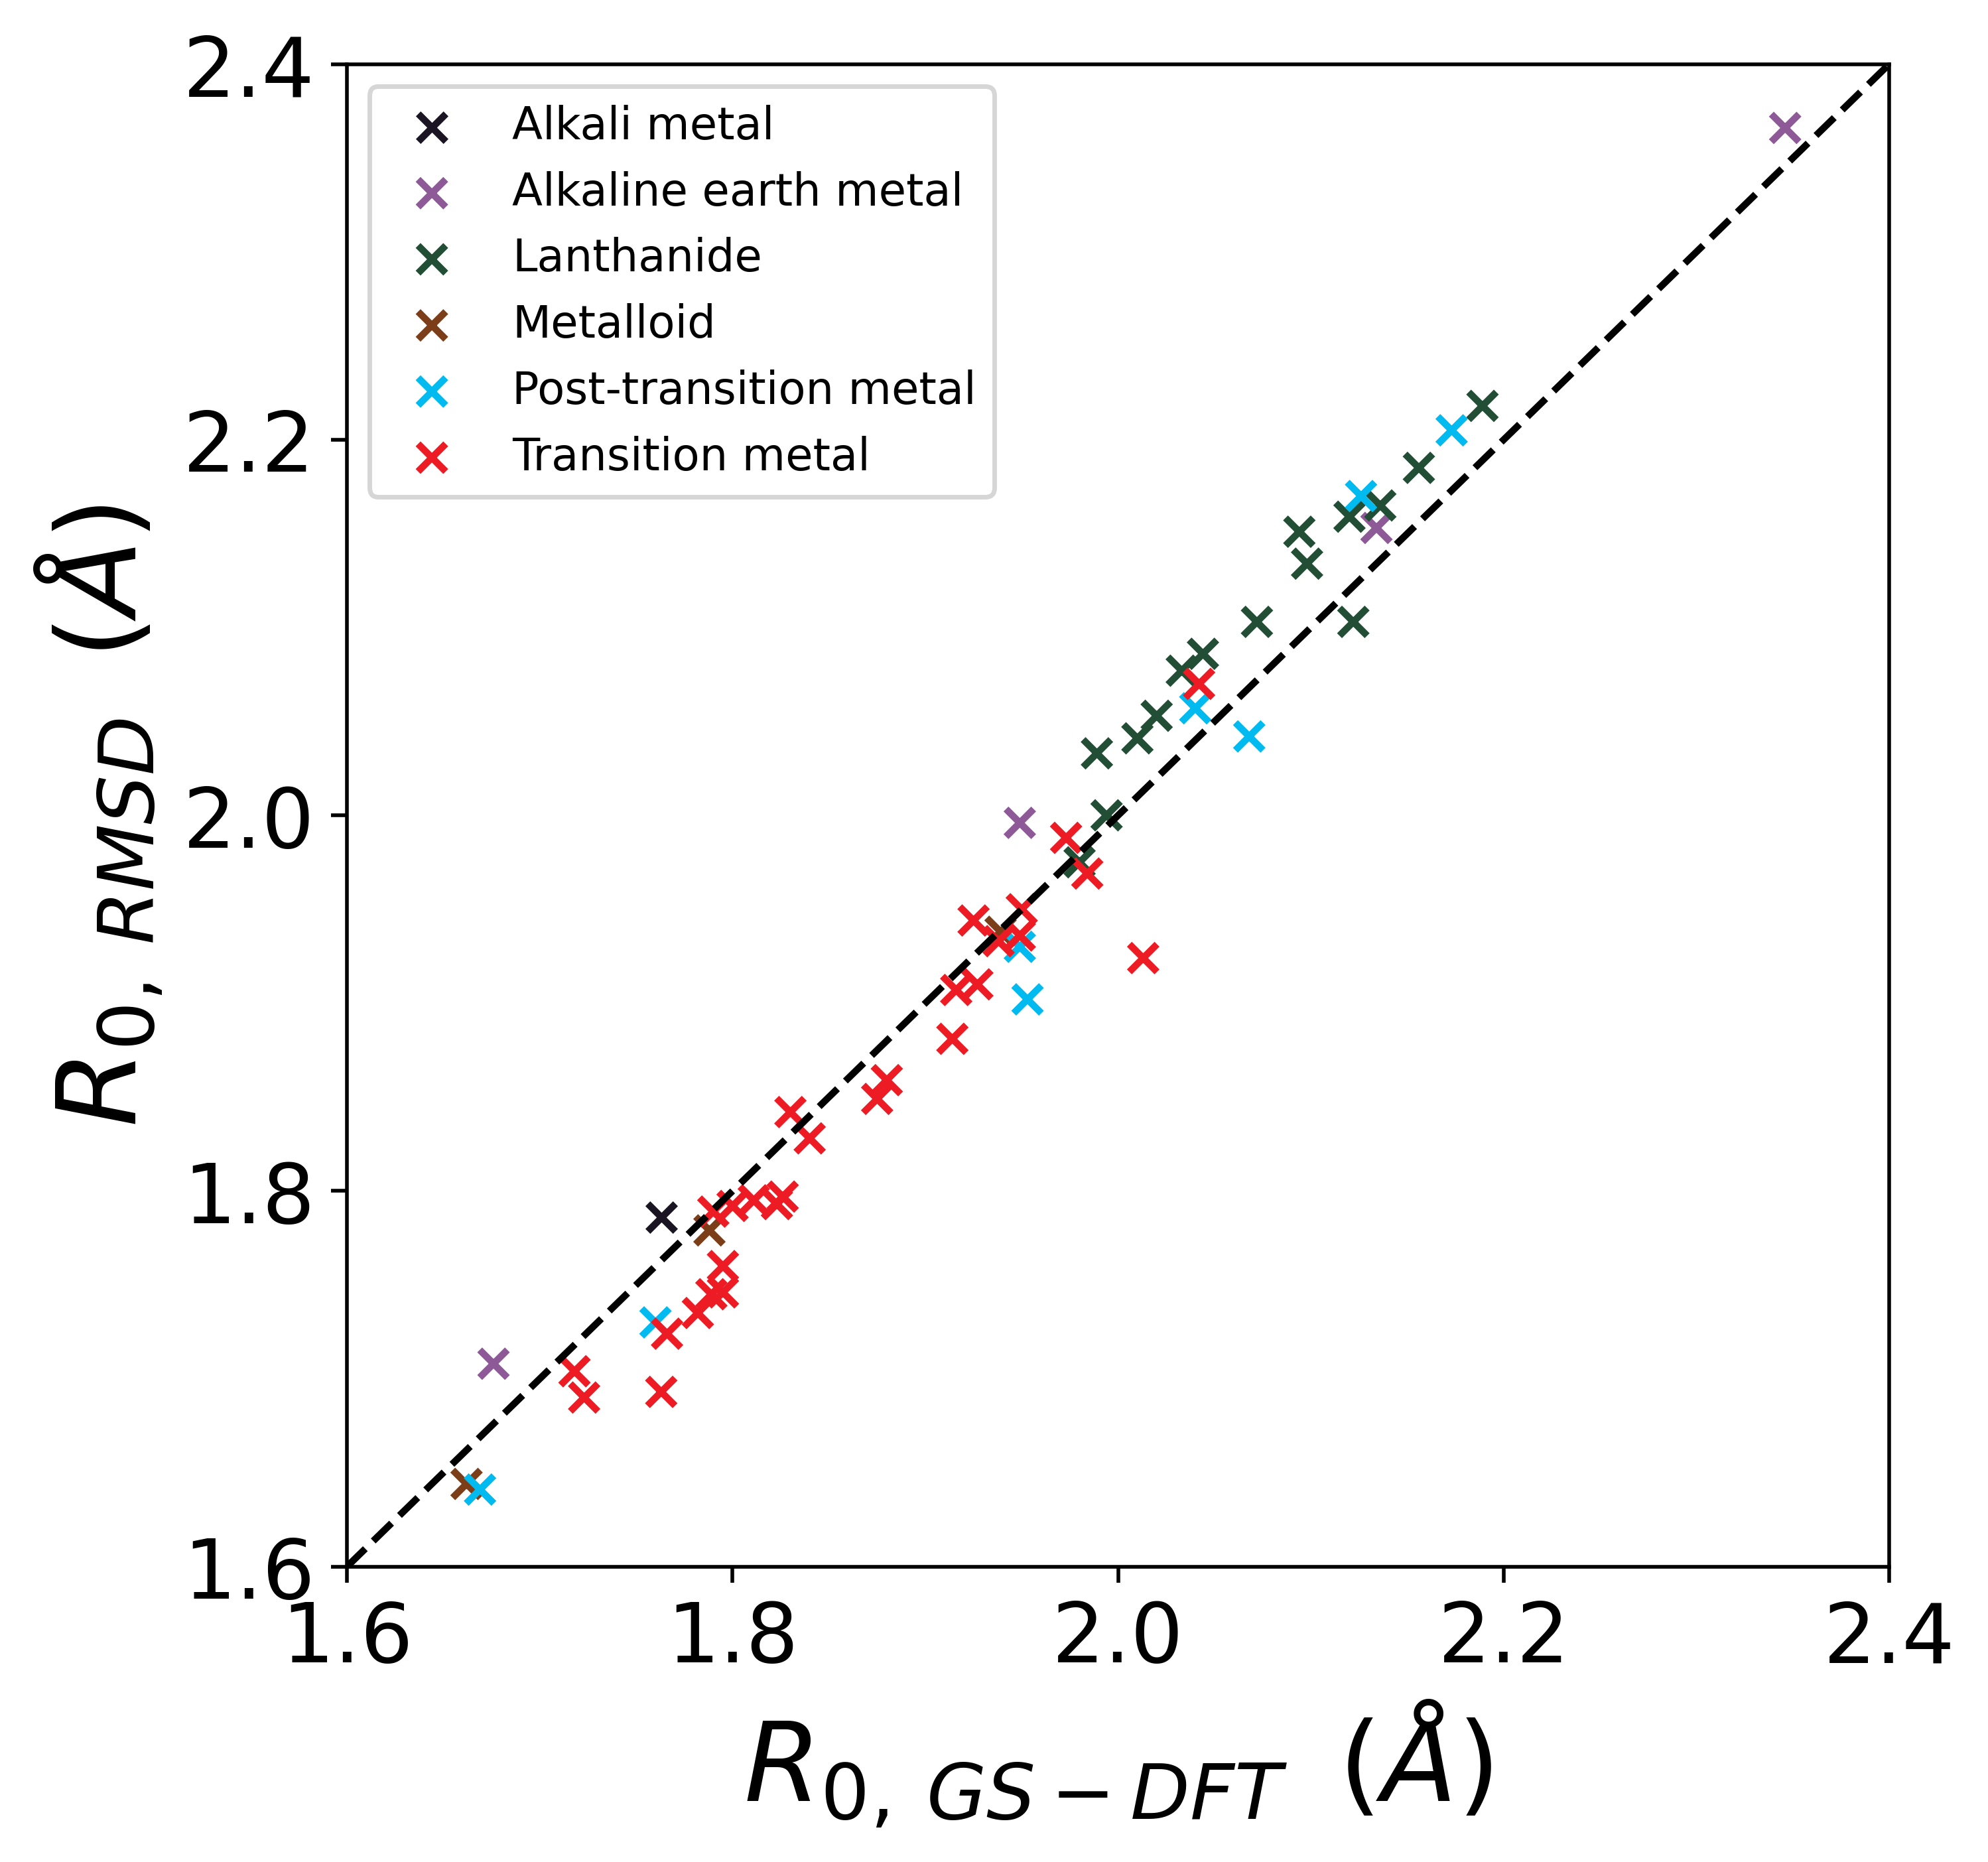

In [32]:
compare_rmsd_to_gs_dft_R0(g_rmsd_params_dct, g_08_params_dct, name='figures/compare_R0_parameters.png')

## Compare the tbv of RMSD to GS DFT

In [33]:
from visualization import compare_tbvs

In [34]:
with open('tbv_compositions/188_compositions_with_sites_designated.json') as f:
    tbv_dct = json.load(f)

In [35]:
for cmpd in list(tbv_dct.keys()):
    tbv_dct[cmpd]['A_sites'] = [Specie.from_dict(a) for a in tbv_dct[cmpd]['A_sites']]
    tbv_dct[cmpd]['B_sites'] = [Specie.from_dict(b) for b in tbv_dct[cmpd]['B_sites']]
    tbv_dct[cmpd]['X_sites'] = [Specie.from_dict(x) for x in tbv_dct[cmpd]['X_sites']]

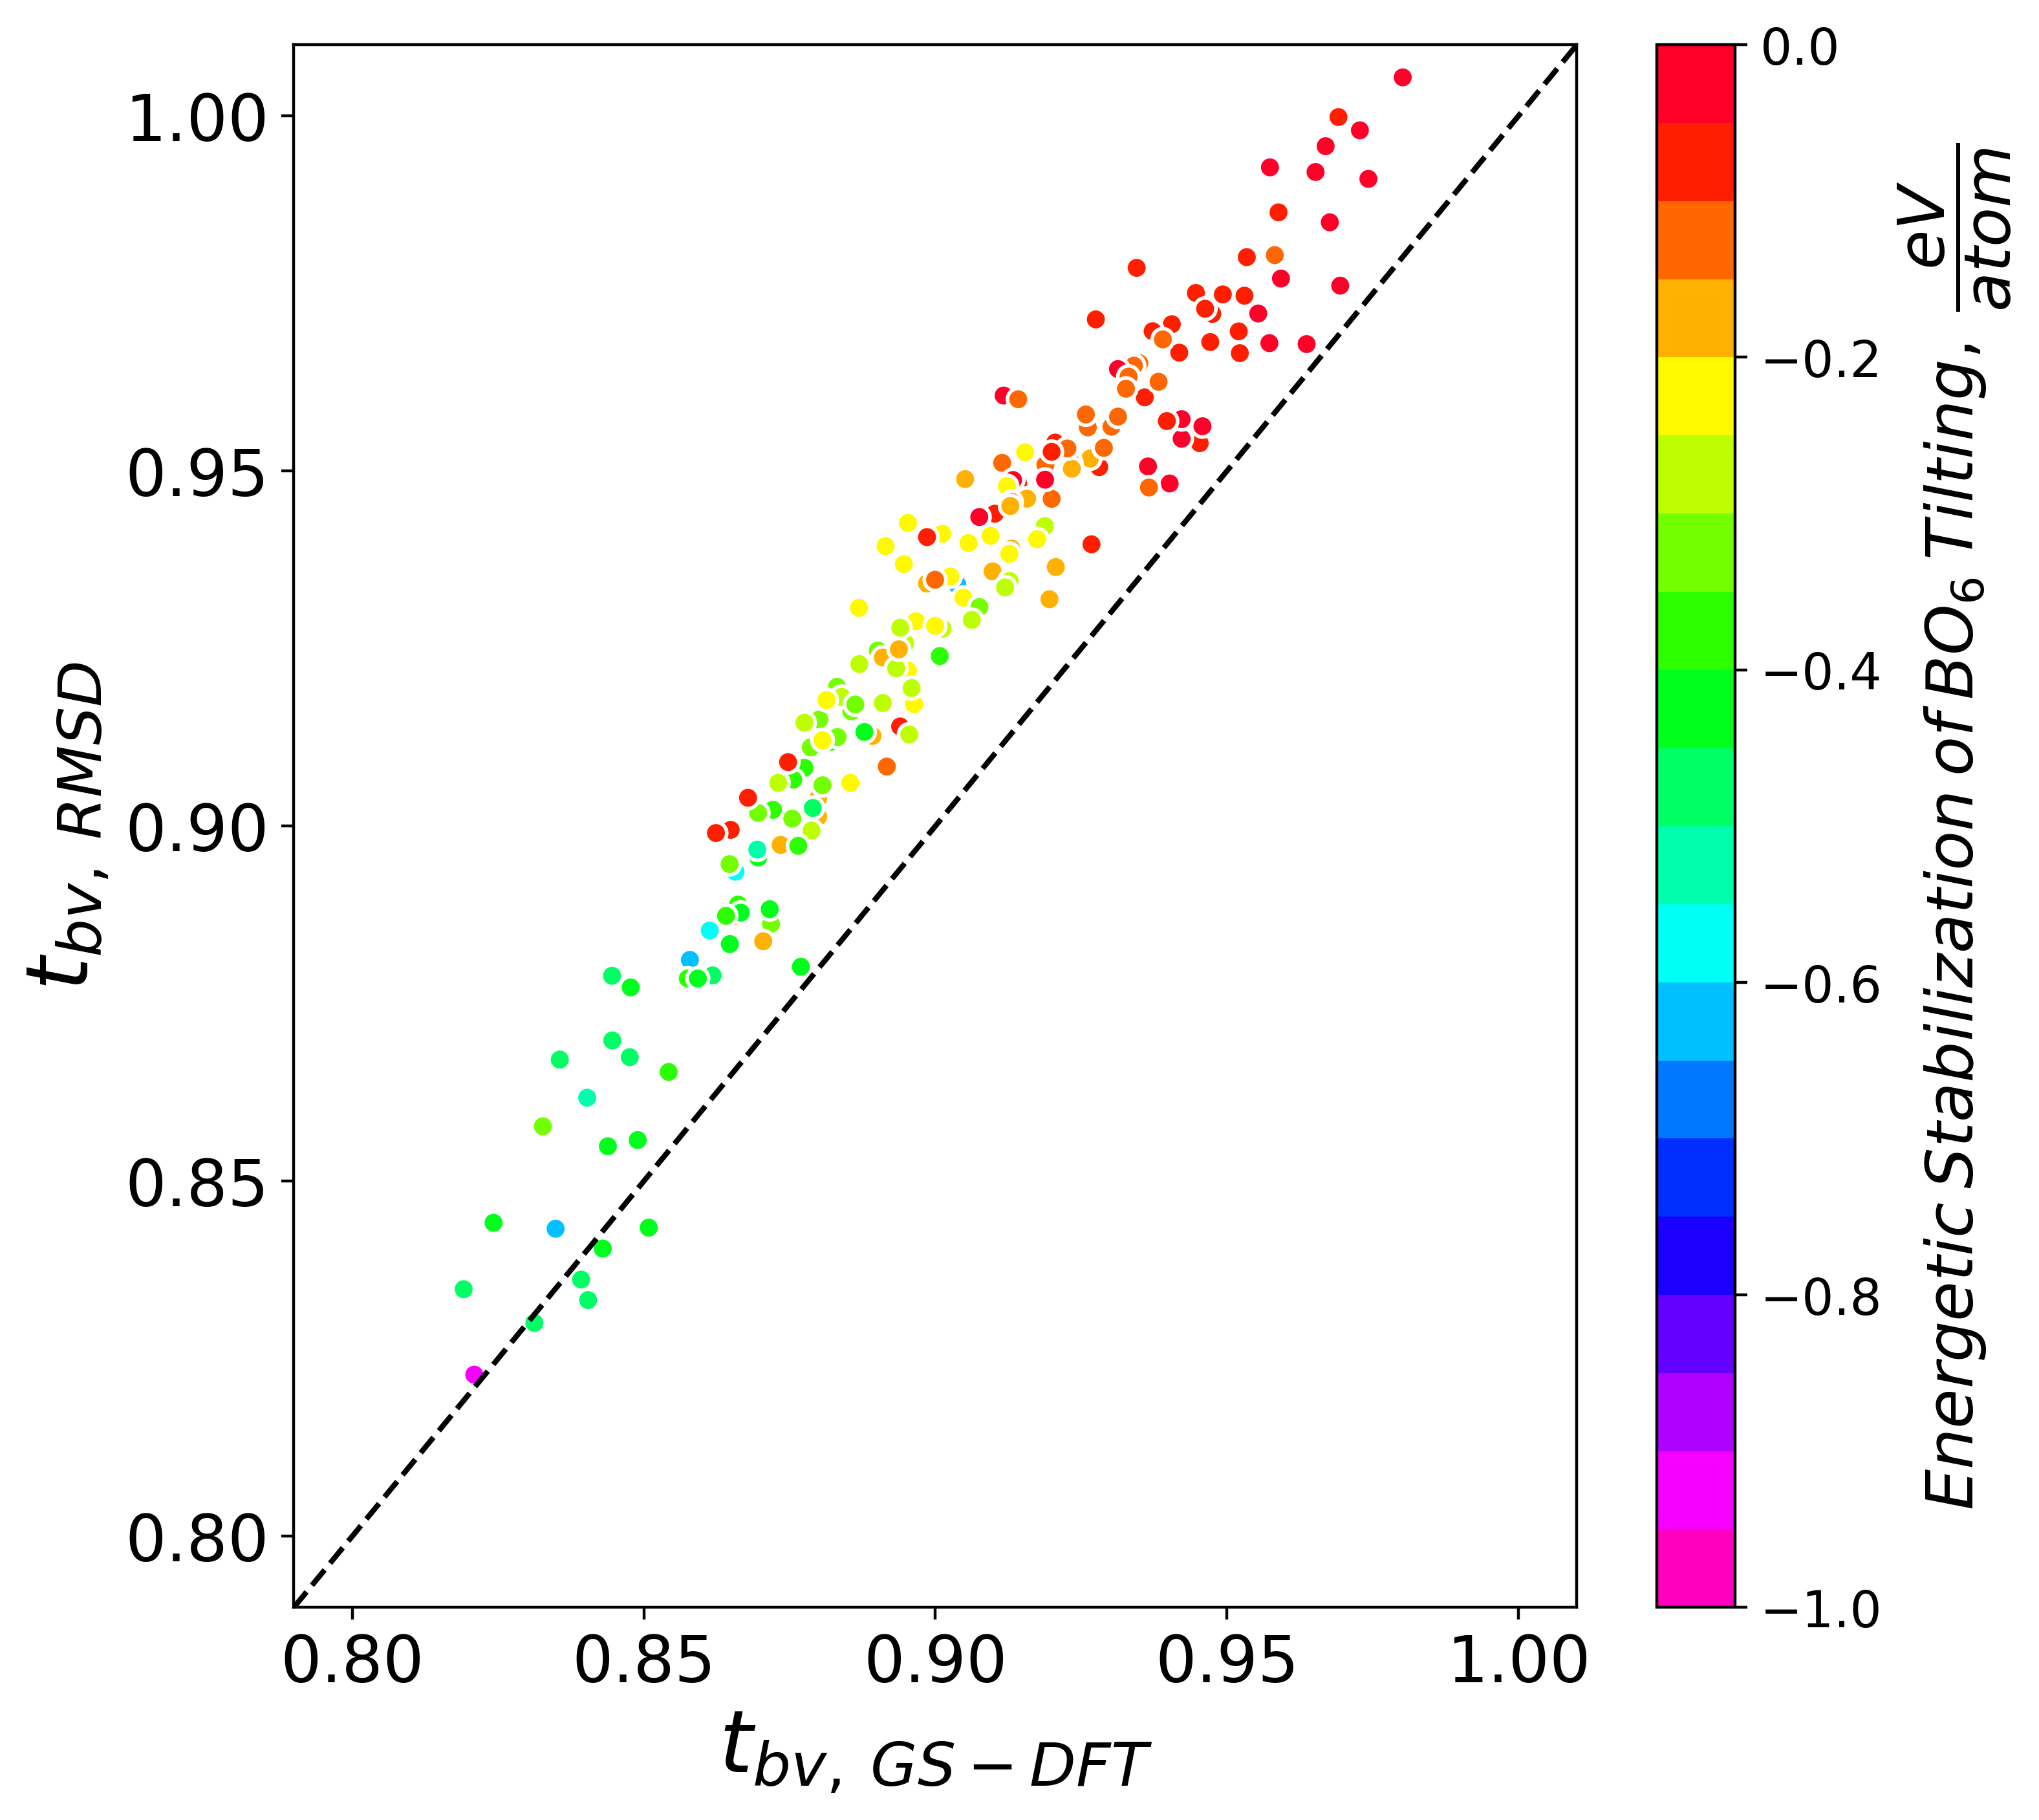

In [37]:
compare_tbvs(tbv_dct, g_rmsd_params_dct, g_08_params_dct, dct, name='figures/compare_tbvs.png')